# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

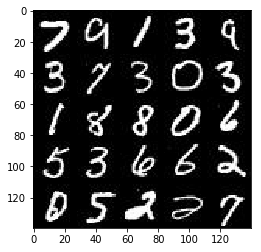

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

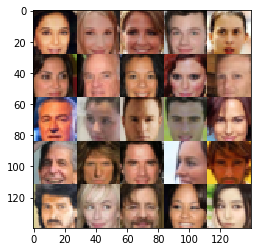

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [13]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learn_rate = tf.placeholder(tf.float32, name="learn_rate")

    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [22]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2

    with tf.variable_scope("discriminator", reuse=reuse):
        # 28x28
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        rel1 = tf.maximum(alpha * x1, x1)
        
        # 14x14x64
        x2 = tf.layers.conv2d(rel1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        rel2 = tf.maximum(alpha * bn2, bn2)
        
        # 7x7x128
        x3 = tf.layers.conv2d(rel1, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        rel3 = tf.maximum(alpha * bn3, bn3)
        
        # 4x4x256
        flat = tf.reshape(rel3, (-1, (4*4*256)))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
    
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    alpha = 0.2
    with tf.variable_scope("generator", reuse=(not is_train)):
        
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        rel1 = tf.maximum(alpha * bn1, bn1)
        
        # 4x4x512
        
        x2 = tf.layers.conv2d_transpose(rel1, 256, 4, strides=1, padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        rel2 = tf.maximum(alpha * bn2, bn2)
        
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(rel2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        rel3 = tf.maximum(alpha * bn3, bn3)
        
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(rel3, out_channel_dim, 5, strides=2, padding='same')
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
class GAN:
    def __init__(self, real_size, z_size, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z, self.learn_rate = model_inputs(real_size[0], real_size[1], real_size[2], z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2])
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learn_rate, beta1)

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    real_size = data_shape[1:]    
    net = GAN(real_size, z_dim, beta1=beta1)
            
    batch_count = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_count += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learn_rate: learning_rate})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images, net.learn_rate: learning_rate})
            
                if batch_count % 20 == 0:
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if batch_count % 100 == 0:
                    show_generator_output(sess, 16, net.input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 1.6257... Generator Loss: 0.3834
Epoch 1/2... Discriminator Loss: 1.3744... Generator Loss: 0.5327
Epoch 1/2... Discriminator Loss: 1.5562... Generator Loss: 0.4863
Epoch 1/2... Discriminator Loss: 1.5254... Generator Loss: 0.5136
Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 0.6244
Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 0.6169
Epoch 1/2... Discriminator Loss: 1.2810... Generator Loss: 0.6357
Epoch 1/2... Discriminator Loss: 1.3418... Generator Loss: 0.5954
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.5860
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 0.6907


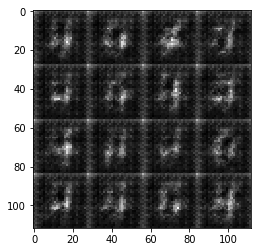

Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 0.5757
Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.6815
Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 0.6369
Epoch 1/2... Discriminator Loss: 1.2938... Generator Loss: 0.6745
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.7069
Epoch 1/2... Discriminator Loss: 1.2789... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 0.6548
Epoch 1/2... Discriminator Loss: 1.2873... Generator Loss: 0.7111
Epoch 1/2... Discriminator Loss: 1.2435... Generator Loss: 0.7167
Epoch 1/2... Discriminator Loss: 1.3164... Generator Loss: 0.6780


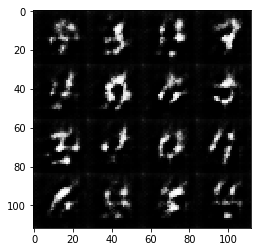

Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 0.6768
Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 0.7128
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 0.7961
Epoch 1/2... Discriminator Loss: 1.3098... Generator Loss: 0.6949
Epoch 1/2... Discriminator Loss: 1.2734... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 0.6862
Epoch 1/2... Discriminator Loss: 1.2436... Generator Loss: 0.7191
Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 0.7439
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 1.3134... Generator Loss: 0.7051


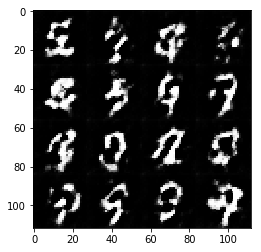

Epoch 1/2... Discriminator Loss: 1.1935... Generator Loss: 0.7618
Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 0.7515
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 0.7397
Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 0.7562
Epoch 1/2... Discriminator Loss: 1.2689... Generator Loss: 0.7046
Epoch 1/2... Discriminator Loss: 1.2309... Generator Loss: 0.7220
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.6796
Epoch 1/2... Discriminator Loss: 1.3124... Generator Loss: 0.7003
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.7378


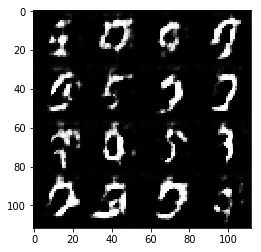

Epoch 1/2... Discriminator Loss: 1.2876... Generator Loss: 0.7005
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 0.7252
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 0.7106
Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 0.7489
Epoch 1/2... Discriminator Loss: 1.2043... Generator Loss: 0.7410
Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 0.7561
Epoch 1/2... Discriminator Loss: 1.2769... Generator Loss: 0.7544
Epoch 1/2... Discriminator Loss: 1.2840... Generator Loss: 0.7392


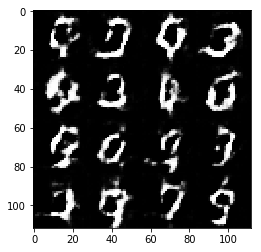

Epoch 1/2... Discriminator Loss: 1.2514... Generator Loss: 0.7376
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 0.7380
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.6732
Epoch 1/2... Discriminator Loss: 1.2055... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 1.2222... Generator Loss: 0.7596
Epoch 1/2... Discriminator Loss: 1.1914... Generator Loss: 0.7960
Epoch 1/2... Discriminator Loss: 1.2414... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 0.8177


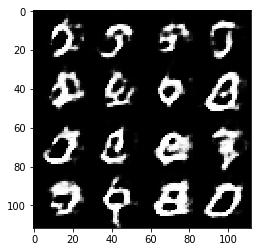

Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.7622
Epoch 1/2... Discriminator Loss: 1.2391... Generator Loss: 0.7683
Epoch 1/2... Discriminator Loss: 1.2591... Generator Loss: 0.7413
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.8023
Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 0.7109
Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 0.7191
Epoch 1/2... Discriminator Loss: 1.2060... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.2476... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 0.7420
Epoch 1/2... Discriminator Loss: 1.3067... Generator Loss: 0.7088


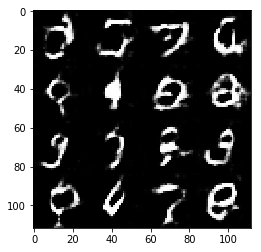

Epoch 1/2... Discriminator Loss: 1.2810... Generator Loss: 0.7360
Epoch 1/2... Discriminator Loss: 1.2570... Generator Loss: 0.7269
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 0.7644
Epoch 1/2... Discriminator Loss: 1.2193... Generator Loss: 0.7695
Epoch 1/2... Discriminator Loss: 1.2524... Generator Loss: 0.7502
Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 0.7512
Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.7483
Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 0.8200
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 0.8447


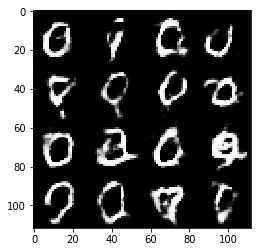

Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 0.7396
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 0.7700
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.7497
Epoch 1/2... Discriminator Loss: 1.2956... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 0.7681
Epoch 1/2... Discriminator Loss: 1.2200... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 1.2524... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 0.7943
Epoch 1/2... Discriminator Loss: 1.1698... Generator Loss: 0.8003
Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 0.7718


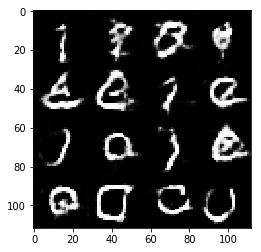

Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 0.7591
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.7527
Epoch 1/2... Discriminator Loss: 1.2860... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 1.1804... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 1.2328... Generator Loss: 0.7540
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.2643... Generator Loss: 0.7412
Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 0.7990
Epoch 1/2... Discriminator Loss: 1.2590... Generator Loss: 0.7357
Epoch 1/2... Discriminator Loss: 1.2432... Generator Loss: 0.7292


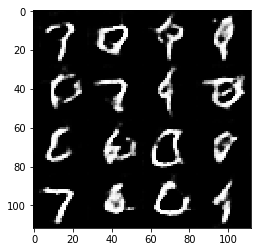

Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 0.7619
Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.7696
Epoch 1/2... Discriminator Loss: 1.1984... Generator Loss: 0.8110
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 0.7365
Epoch 1/2... Discriminator Loss: 1.2827... Generator Loss: 0.7065
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.7964
Epoch 1/2... Discriminator Loss: 1.2478... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 1.2584... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 0.6953


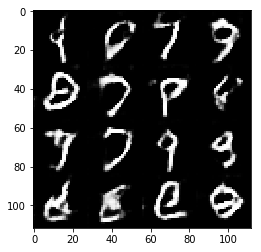

Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 0.7617
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 0.7470
Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 0.7171
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.7607
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.7566
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.7925
Epoch 1/2... Discriminator Loss: 1.2317... Generator Loss: 0.7361
Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 1.2699... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 0.7651


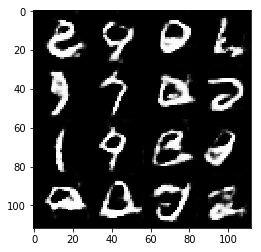

Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.7717
Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 0.7441
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 1.1862... Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 1.2122... Generator Loss: 0.8221
Epoch 1/2... Discriminator Loss: 1.1478... Generator Loss: 0.8441
Epoch 1/2... Discriminator Loss: 1.2414... Generator Loss: 0.7826
Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 0.8721
Epoch 1/2... Discriminator Loss: 1.1588... Generator Loss: 0.7639
Epoch 1/2... Discriminator Loss: 1.2006... Generator Loss: 0.7619


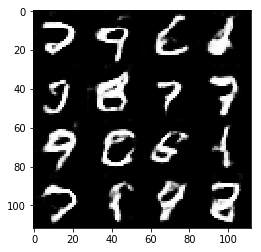

Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 0.7087
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.7140
Epoch 1/2... Discriminator Loss: 1.2350... Generator Loss: 0.7044
Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 0.7352
Epoch 1/2... Discriminator Loss: 1.2549... Generator Loss: 0.8792
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 1.2261... Generator Loss: 0.7565
Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 0.6263
Epoch 1/2... Discriminator Loss: 1.2721... Generator Loss: 0.7382
Epoch 1/2... Discriminator Loss: 1.2081... Generator Loss: 0.7086


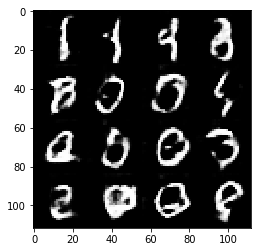

Epoch 1/2... Discriminator Loss: 1.2485... Generator Loss: 0.7314
Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 0.8306
Epoch 1/2... Discriminator Loss: 1.2411... Generator Loss: 0.9273
Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 0.7680
Epoch 1/2... Discriminator Loss: 1.1983... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 1.1938... Generator Loss: 0.8123
Epoch 1/2... Discriminator Loss: 1.1639... Generator Loss: 0.7002
Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 0.6977
Epoch 1/2... Discriminator Loss: 1.2122... Generator Loss: 0.7464


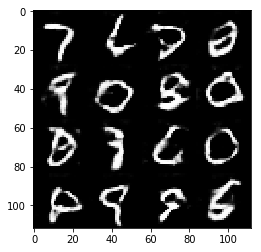

Epoch 1/2... Discriminator Loss: 1.1973... Generator Loss: 0.7264
Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 0.7401
Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 0.8443
Epoch 1/2... Discriminator Loss: 1.1181... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.8185
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 0.9874
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 1.2541... Generator Loss: 0.7164
Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 0.8115
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 0.7544


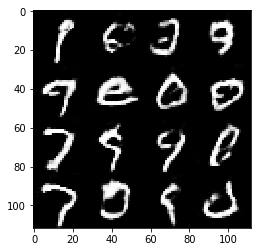

Epoch 1/2... Discriminator Loss: 1.1677... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 1.1695... Generator Loss: 0.9096
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 0.7496
Epoch 1/2... Discriminator Loss: 1.2155... Generator Loss: 0.8280
Epoch 1/2... Discriminator Loss: 1.1408... Generator Loss: 0.7681
Epoch 1/2... Discriminator Loss: 1.2820... Generator Loss: 1.0854
Epoch 1/2... Discriminator Loss: 1.2077... Generator Loss: 0.8167
Epoch 1/2... Discriminator Loss: 1.1407... Generator Loss: 0.7939
Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 0.7992
Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 0.6426


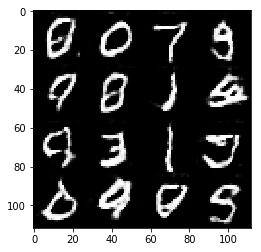

Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 0.7677
Epoch 1/2... Discriminator Loss: 1.2491... Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 1.1633... Generator Loss: 0.8507
Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 1.1790... Generator Loss: 0.7923
Epoch 1/2... Discriminator Loss: 1.1819... Generator Loss: 0.7238
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 1.1832... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.8125
Epoch 1/2... Discriminator Loss: 1.1524... Generator Loss: 0.8610


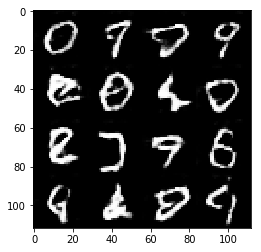

Epoch 1/2... Discriminator Loss: 1.1967... Generator Loss: 0.8094
Epoch 1/2... Discriminator Loss: 1.2282... Generator Loss: 0.7844
Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 1.0398
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 0.8495
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 0.7704
Epoch 1/2... Discriminator Loss: 1.1742... Generator Loss: 0.7283
Epoch 2/2... Discriminator Loss: 1.1465... Generator Loss: 0.8931
Epoch 2/2... Discriminator Loss: 1.1828... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 1.1466... Generator Loss: 0.8280


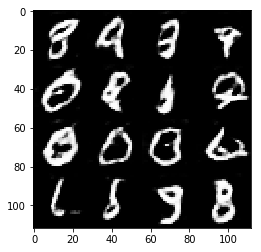

Epoch 2/2... Discriminator Loss: 1.1897... Generator Loss: 0.8705
Epoch 2/2... Discriminator Loss: 1.2016... Generator Loss: 0.9278
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 0.7452
Epoch 2/2... Discriminator Loss: 1.1303... Generator Loss: 0.8300
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.7450
Epoch 2/2... Discriminator Loss: 1.1798... Generator Loss: 0.7614
Epoch 2/2... Discriminator Loss: 1.0902... Generator Loss: 0.8846
Epoch 2/2... Discriminator Loss: 1.2295... Generator Loss: 0.7222
Epoch 2/2... Discriminator Loss: 1.2366... Generator Loss: 0.7642
Epoch 2/2... Discriminator Loss: 1.1896... Generator Loss: 0.7561


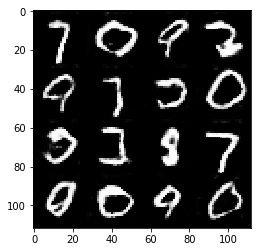

Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 0.7074
Epoch 2/2... Discriminator Loss: 1.1354... Generator Loss: 0.8693
Epoch 2/2... Discriminator Loss: 1.1101... Generator Loss: 0.8057
Epoch 2/2... Discriminator Loss: 1.2779... Generator Loss: 0.9748
Epoch 2/2... Discriminator Loss: 1.2230... Generator Loss: 0.7708
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 1.1910... Generator Loss: 0.8032
Epoch 2/2... Discriminator Loss: 1.2143... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 0.8125
Epoch 2/2... Discriminator Loss: 1.1234... Generator Loss: 0.7407


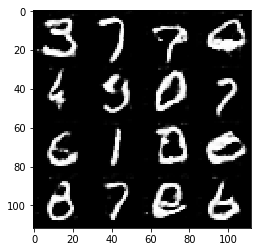

Epoch 2/2... Discriminator Loss: 1.1858... Generator Loss: 0.7692
Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.8277
Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 0.8255
Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 0.7989
Epoch 2/2... Discriminator Loss: 1.1292... Generator Loss: 0.9411
Epoch 2/2... Discriminator Loss: 1.2837... Generator Loss: 1.0101
Epoch 2/2... Discriminator Loss: 1.1331... Generator Loss: 0.8341
Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 0.9367
Epoch 2/2... Discriminator Loss: 1.1537... Generator Loss: 0.8046


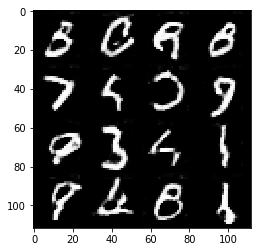

Epoch 2/2... Discriminator Loss: 1.1534... Generator Loss: 0.7738
Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 0.8223
Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 0.9538
Epoch 2/2... Discriminator Loss: 1.0902... Generator Loss: 0.9952
Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 1.0059
Epoch 2/2... Discriminator Loss: 1.1531... Generator Loss: 0.8777
Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 0.8113
Epoch 2/2... Discriminator Loss: 1.0778... Generator Loss: 0.8167
Epoch 2/2... Discriminator Loss: 1.0953... Generator Loss: 0.8998
Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 0.7244


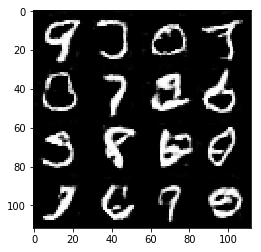

Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 0.6237
Epoch 2/2... Discriminator Loss: 1.1931... Generator Loss: 0.9530
Epoch 2/2... Discriminator Loss: 1.1949... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 1.0110
Epoch 2/2... Discriminator Loss: 1.1153... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 1.2319... Generator Loss: 0.8107
Epoch 2/2... Discriminator Loss: 1.1735... Generator Loss: 0.8562
Epoch 2/2... Discriminator Loss: 1.1586... Generator Loss: 0.7833
Epoch 2/2... Discriminator Loss: 1.1002... Generator Loss: 0.8643
Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.8150


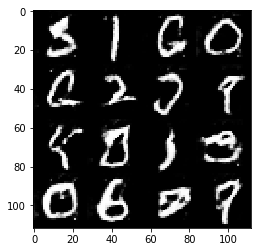

Epoch 2/2... Discriminator Loss: 1.1088... Generator Loss: 0.8243
Epoch 2/2... Discriminator Loss: 1.1763... Generator Loss: 0.9979
Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 0.8153
Epoch 2/2... Discriminator Loss: 1.1059... Generator Loss: 0.9018
Epoch 2/2... Discriminator Loss: 1.1988... Generator Loss: 0.7545
Epoch 2/2... Discriminator Loss: 1.1451... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 1.1623... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 1.1481... Generator Loss: 0.8158
Epoch 2/2... Discriminator Loss: 1.0931... Generator Loss: 0.8161
Epoch 2/2... Discriminator Loss: 1.1805... Generator Loss: 0.6641


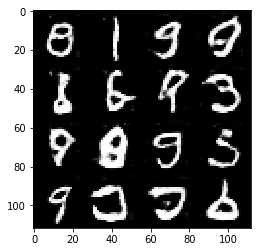

Epoch 2/2... Discriminator Loss: 1.1335... Generator Loss: 0.8708
Epoch 2/2... Discriminator Loss: 1.1780... Generator Loss: 0.8339
Epoch 2/2... Discriminator Loss: 1.1665... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 0.9358
Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 0.8617
Epoch 2/2... Discriminator Loss: 1.0966... Generator Loss: 0.9869
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 0.9068
Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 0.9106
Epoch 2/2... Discriminator Loss: 1.3040... Generator Loss: 0.5629
Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 0.7953


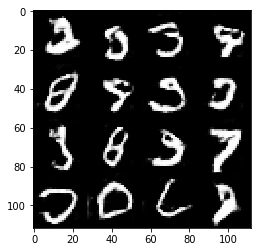

Epoch 2/2... Discriminator Loss: 1.0781... Generator Loss: 0.9281
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 0.9537
Epoch 2/2... Discriminator Loss: 1.2797... Generator Loss: 0.6726
Epoch 2/2... Discriminator Loss: 1.0915... Generator Loss: 0.8250
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 1.1075... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 1.1115... Generator Loss: 0.8816
Epoch 2/2... Discriminator Loss: 1.1231... Generator Loss: 0.8457
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.8158
Epoch 2/2... Discriminator Loss: 1.0727... Generator Loss: 0.8736


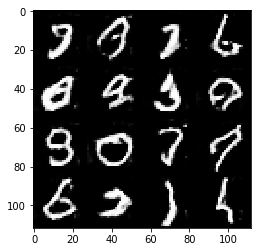

Epoch 2/2... Discriminator Loss: 1.1153... Generator Loss: 0.8339
Epoch 2/2... Discriminator Loss: 1.1632... Generator Loss: 0.9370
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 0.8158
Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 0.9256
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 0.8450
Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 0.9760
Epoch 2/2... Discriminator Loss: 1.1221... Generator Loss: 0.8522
Epoch 2/2... Discriminator Loss: 1.1098... Generator Loss: 0.7842
Epoch 2/2... Discriminator Loss: 1.1712... Generator Loss: 0.7321
Epoch 2/2... Discriminator Loss: 1.0898... Generator Loss: 0.9550


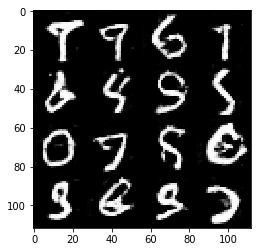

Epoch 2/2... Discriminator Loss: 1.0844... Generator Loss: 0.8012
Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 0.8875
Epoch 2/2... Discriminator Loss: 1.1127... Generator Loss: 1.0180
Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 1.0389
Epoch 2/2... Discriminator Loss: 1.0728... Generator Loss: 0.9606
Epoch 2/2... Discriminator Loss: 1.1821... Generator Loss: 0.7488
Epoch 2/2... Discriminator Loss: 1.4757... Generator Loss: 1.5355
Epoch 2/2... Discriminator Loss: 1.0955... Generator Loss: 0.9109
Epoch 2/2... Discriminator Loss: 1.0585... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 1.0564... Generator Loss: 0.9070


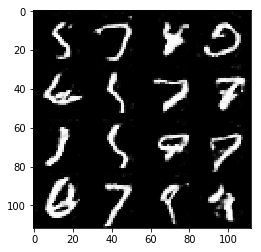

Epoch 2/2... Discriminator Loss: 1.1182... Generator Loss: 0.8695
Epoch 2/2... Discriminator Loss: 1.0813... Generator Loss: 1.0688
Epoch 2/2... Discriminator Loss: 1.1242... Generator Loss: 0.9267
Epoch 2/2... Discriminator Loss: 1.2160... Generator Loss: 0.9275
Epoch 2/2... Discriminator Loss: 1.1958... Generator Loss: 0.8657
Epoch 2/2... Discriminator Loss: 1.1832... Generator Loss: 1.0260
Epoch 2/2... Discriminator Loss: 1.1172... Generator Loss: 0.9095
Epoch 2/2... Discriminator Loss: 1.1993... Generator Loss: 0.7979
Epoch 2/2... Discriminator Loss: 1.1723... Generator Loss: 0.8538
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 0.7814


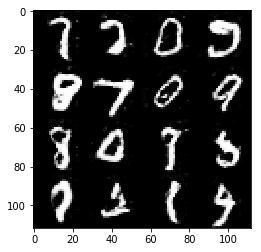

Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 0.8629
Epoch 2/2... Discriminator Loss: 1.1032... Generator Loss: 0.8625
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 0.9285
Epoch 2/2... Discriminator Loss: 1.4165... Generator Loss: 0.8371
Epoch 2/2... Discriminator Loss: 1.1186... Generator Loss: 0.7751
Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 0.9719
Epoch 2/2... Discriminator Loss: 1.1516... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 0.7155
Epoch 2/2... Discriminator Loss: 1.1931... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.1170... Generator Loss: 0.8094


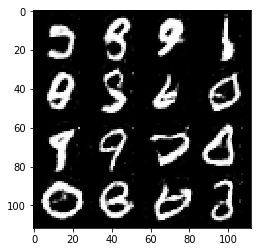

Epoch 2/2... Discriminator Loss: 1.1743... Generator Loss: 0.9567
Epoch 2/2... Discriminator Loss: 1.4052... Generator Loss: 1.0045
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.8646
Epoch 2/2... Discriminator Loss: 1.1901... Generator Loss: 0.7456
Epoch 2/2... Discriminator Loss: 1.1365... Generator Loss: 0.8724
Epoch 2/2... Discriminator Loss: 1.0966... Generator Loss: 0.9222
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 0.7671
Epoch 2/2... Discriminator Loss: 1.1414... Generator Loss: 0.8638
Epoch 2/2... Discriminator Loss: 1.1461... Generator Loss: 0.8053
Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 0.9524


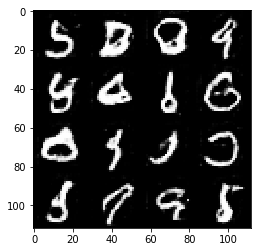

Epoch 2/2... Discriminator Loss: 1.1958... Generator Loss: 0.8092
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 0.9259
Epoch 2/2... Discriminator Loss: 1.2567... Generator Loss: 1.0396
Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 0.8883
Epoch 2/2... Discriminator Loss: 1.1211... Generator Loss: 0.9423
Epoch 2/2... Discriminator Loss: 1.1399... Generator Loss: 0.8094
Epoch 2/2... Discriminator Loss: 1.0747... Generator Loss: 0.8723
Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 0.7956
Epoch 2/2... Discriminator Loss: 1.1248... Generator Loss: 1.0008
Epoch 2/2... Discriminator Loss: 1.0633... Generator Loss: 0.8771


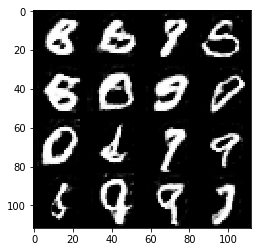

Epoch 2/2... Discriminator Loss: 1.1144... Generator Loss: 0.8534
Epoch 2/2... Discriminator Loss: 1.0951... Generator Loss: 0.8397
Epoch 2/2... Discriminator Loss: 1.1398... Generator Loss: 0.8376
Epoch 2/2... Discriminator Loss: 1.1282... Generator Loss: 0.8619
Epoch 2/2... Discriminator Loss: 1.1360... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 1.1856... Generator Loss: 0.7326
Epoch 2/2... Discriminator Loss: 1.2637... Generator Loss: 0.7052
Epoch 2/2... Discriminator Loss: 1.0637... Generator Loss: 0.8476
Epoch 2/2... Discriminator Loss: 1.1051... Generator Loss: 0.8456
Epoch 2/2... Discriminator Loss: 1.1042... Generator Loss: 0.8400


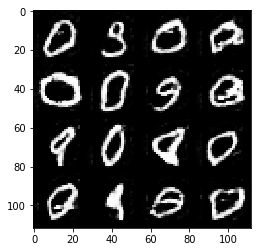

Epoch 2/2... Discriminator Loss: 1.1168... Generator Loss: 0.8584
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 0.8599
Epoch 2/2... Discriminator Loss: 1.0878... Generator Loss: 1.1779
Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 0.9942
Epoch 2/2... Discriminator Loss: 1.1439... Generator Loss: 0.8215
Epoch 2/2... Discriminator Loss: 1.0932... Generator Loss: 0.8596
Epoch 2/2... Discriminator Loss: 1.1678... Generator Loss: 0.7383
Epoch 2/2... Discriminator Loss: 1.1363... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 1.0567... Generator Loss: 0.8728
Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 0.8191


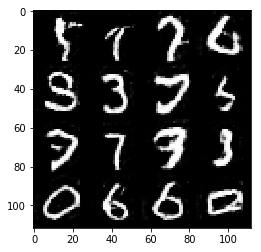

Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 0.8487
Epoch 2/2... Discriminator Loss: 1.1410... Generator Loss: 0.7819
Epoch 2/2... Discriminator Loss: 1.1200... Generator Loss: 0.7702
Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 1.0416
Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 0.8872
Epoch 2/2... Discriminator Loss: 1.1983... Generator Loss: 0.7521
Epoch 2/2... Discriminator Loss: 1.1369... Generator Loss: 0.8092
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.6648
Epoch 2/2... Discriminator Loss: 1.1277... Generator Loss: 0.9627
Epoch 2/2... Discriminator Loss: 1.1388... Generator Loss: 0.9263


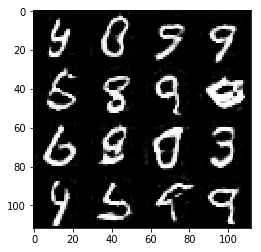

Epoch 2/2... Discriminator Loss: 1.1753... Generator Loss: 0.6966
Epoch 2/2... Discriminator Loss: 1.0892... Generator Loss: 0.8565
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 1.1785... Generator Loss: 0.8948
Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 0.9001
Epoch 2/2... Discriminator Loss: 1.1704... Generator Loss: 0.9214
Epoch 2/2... Discriminator Loss: 1.1673... Generator Loss: 0.9189
Epoch 2/2... Discriminator Loss: 1.1477... Generator Loss: 0.8662
Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 0.8781
Epoch 2/2... Discriminator Loss: 1.1277... Generator Loss: 0.9084


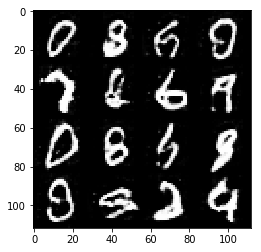

Epoch 2/2... Discriminator Loss: 1.1145... Generator Loss: 0.8842
Epoch 2/2... Discriminator Loss: 1.1427... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 1.1550... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.0996... Generator Loss: 0.9088
Epoch 2/2... Discriminator Loss: 1.1987... Generator Loss: 0.8847


IndexError: list index out of range

In [23]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 2.0602... Generator Loss: 0.2863
Epoch 1/1... Discriminator Loss: 1.6530... Generator Loss: 0.4489
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.7687


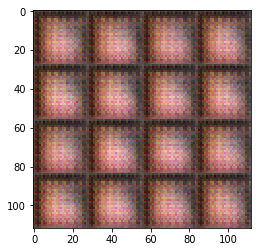

Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.0694
Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 1.1102
Epoch 1/1... Discriminator Loss: 0.6627... Generator Loss: 1.3146
Epoch 1/1... Discriminator Loss: 0.5766... Generator Loss: 1.5115
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 1.5444
Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 0.5071... Generator Loss: 1.4355
Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 1.5794


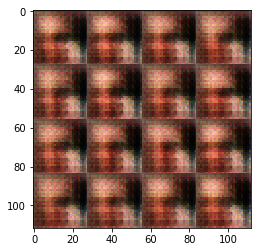

Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 2.3428
Epoch 1/1... Discriminator Loss: 0.4539... Generator Loss: 1.5839
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 1.6332
Epoch 1/1... Discriminator Loss: 0.6148... Generator Loss: 1.5317
Epoch 1/1... Discriminator Loss: 0.3705... Generator Loss: 2.1678
Epoch 1/1... Discriminator Loss: 0.3974... Generator Loss: 1.5782
Epoch 1/1... Discriminator Loss: 0.5542... Generator Loss: 2.9273
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 1.9396
Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 1.7140
Epoch 1/1... Discriminator Loss: 0.3218... Generator Loss: 2.5078


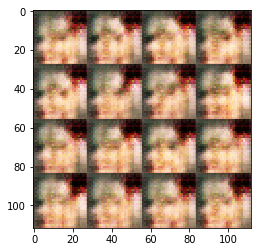

Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 2.0337
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 1.6755
Epoch 1/1... Discriminator Loss: 0.2936... Generator Loss: 2.7262
Epoch 1/1... Discriminator Loss: 0.5110... Generator Loss: 1.5288
Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 1.7189
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 1.7256
Epoch 1/1... Discriminator Loss: 0.3219... Generator Loss: 2.3052
Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 1.9818
Epoch 1/1... Discriminator Loss: 0.2758... Generator Loss: 2.8069
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 1.6274


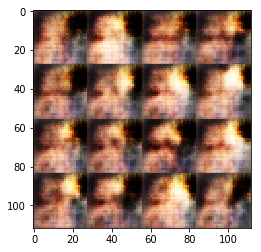

Epoch 1/1... Discriminator Loss: 0.2558... Generator Loss: 3.0118
Epoch 1/1... Discriminator Loss: 0.4022... Generator Loss: 2.1790
Epoch 1/1... Discriminator Loss: 0.5465... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 0.4922... Generator Loss: 2.4792
Epoch 1/1... Discriminator Loss: 0.4572... Generator Loss: 2.0532
Epoch 1/1... Discriminator Loss: 0.5429... Generator Loss: 1.5073
Epoch 1/1... Discriminator Loss: 0.4722... Generator Loss: 1.7937
Epoch 1/1... Discriminator Loss: 0.7103... Generator Loss: 1.5657
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 1.6006
Epoch 1/1... Discriminator Loss: 0.6916... Generator Loss: 1.5086


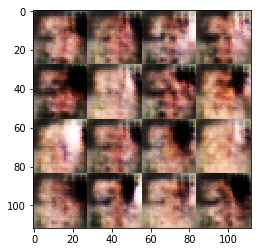

Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 1.3244
Epoch 1/1... Discriminator Loss: 0.7205... Generator Loss: 1.2943
Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 1.7914
Epoch 1/1... Discriminator Loss: 0.3288... Generator Loss: 2.5858
Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 0.4692... Generator Loss: 1.8592
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 1.2862


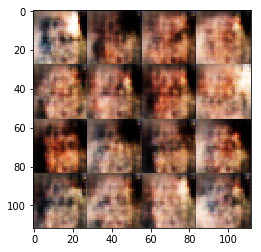

Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 1.4390
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 1.7045
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 0.5780... Generator Loss: 1.7316
Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 1.6680
Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 1.6927
Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 1.4745
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 1.4966
Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 1.4425


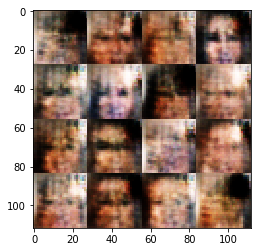

Epoch 1/1... Discriminator Loss: 0.6746... Generator Loss: 1.3455
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 1.7051
Epoch 1/1... Discriminator Loss: 0.5533... Generator Loss: 1.5743
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.6706
Epoch 1/1... Discriminator Loss: 0.6429... Generator Loss: 1.3341
Epoch 1/1... Discriminator Loss: 0.5429... Generator Loss: 1.8606
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 1.3077
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 1.6766
Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 1.9701
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 1.8136


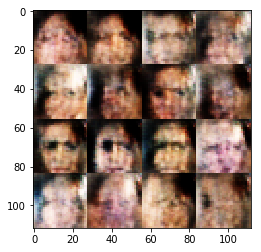

Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 1.8575
Epoch 1/1... Discriminator Loss: 0.6511... Generator Loss: 1.4348
Epoch 1/1... Discriminator Loss: 0.5477... Generator Loss: 1.7127
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 1.2598
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 1.2732
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 1.4242
Epoch 1/1... Discriminator Loss: 0.6813... Generator Loss: 1.3476
Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 1.4648
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.4699
Epoch 1/1... Discriminator Loss: 0.6428... Generator Loss: 1.4815


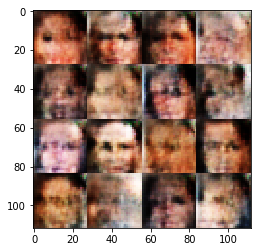

Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 1.2855
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 1.6911
Epoch 1/1... Discriminator Loss: 0.5674... Generator Loss: 1.8546
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 1.4945
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 1.3355
Epoch 1/1... Discriminator Loss: 1.7260... Generator Loss: 1.6079
Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 1.4493
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 1.3147


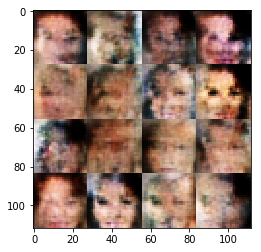

Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 1.4358
Epoch 1/1... Discriminator Loss: 0.8389... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.3048
Epoch 1/1... Discriminator Loss: 0.7845... Generator Loss: 1.2680
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.4623
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 1.3712
Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 1.3125


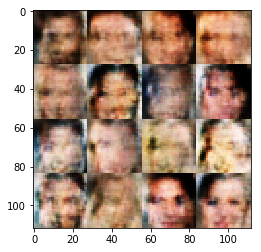

Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 1.3248
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.1999
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.2993
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.2843
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 1.2035
Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 1.5640
Epoch 1/1... Discriminator Loss: 0.6631... Generator Loss: 1.7894
Epoch 1/1... Discriminator Loss: 0.7541... Generator Loss: 1.3575
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.3452


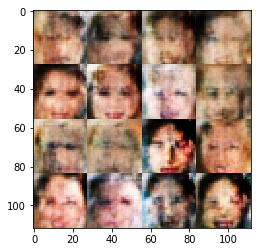

Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.1793
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 1.0338
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.2725
Epoch 1/1... Discriminator Loss: 0.7082... Generator Loss: 1.4490
Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 0.9360


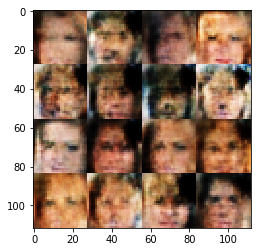

Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 0.4421... Generator Loss: 2.3317
Epoch 1/1... Discriminator Loss: 0.7658... Generator Loss: 1.5789
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.1996
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 1.2863
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.1090
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 0.6676... Generator Loss: 1.2437
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.2837


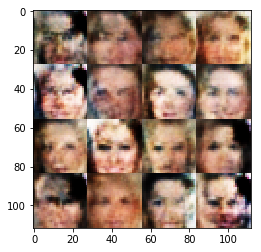

Epoch 1/1... Discriminator Loss: 0.8871... Generator Loss: 1.1072
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.4002
Epoch 1/1... Discriminator Loss: 0.7393... Generator Loss: 1.2169
Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 1.5430
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.3779
Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 1.1689
Epoch 1/1... Discriminator Loss: 1.6226... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 0.5089... Generator Loss: 3.1012
Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 2.1025


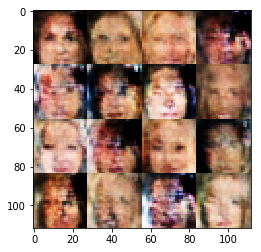

Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.2146
Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 1.1924
Epoch 1/1... Discriminator Loss: 0.7635... Generator Loss: 1.7402
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.7472


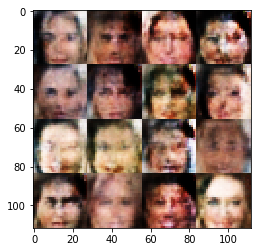

Epoch 1/1... Discriminator Loss: 0.4598... Generator Loss: 2.9609
Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.3598
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 1.1327
Epoch 1/1... Discriminator Loss: 3.0383... Generator Loss: 1.9293
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.1643
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.1623
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.2602


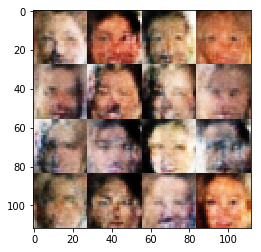

Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.1746
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 1.5361
Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 1.9245
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.0150
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 1.7545


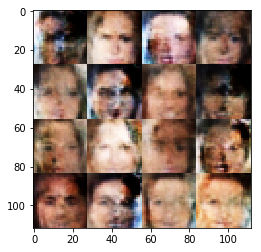

Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.2469
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.2897
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 1.4468
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 0.7289... Generator Loss: 1.5156
Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.2519
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.3030
Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.1844
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 1.0655


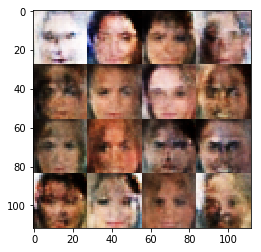

Epoch 1/1... Discriminator Loss: 0.7168... Generator Loss: 1.6336
Epoch 1/1... Discriminator Loss: 0.9096... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.7160
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 0.6656... Generator Loss: 1.6542
Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.3387
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.1423


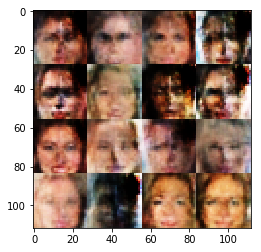

Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 2.5320
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 1.1077
Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 1.1768
Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.3104
Epoch 1/1... Discriminator Loss: 0.4732... Generator Loss: 2.9676


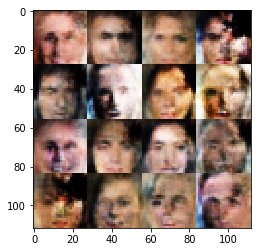

Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 1.2002
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.2385
Epoch 1/1... Discriminator Loss: 0.9191... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.0802


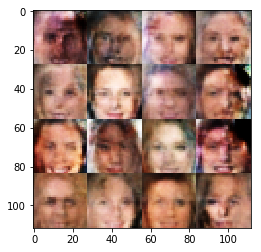

Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.2622
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 2.3261... Generator Loss: 1.7084
Epoch 1/1... Discriminator Loss: 0.7710... Generator Loss: 1.5600
Epoch 1/1... Discriminator Loss: 0.4655... Generator Loss: 3.0299
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 1.2858
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 2.0667
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.9284


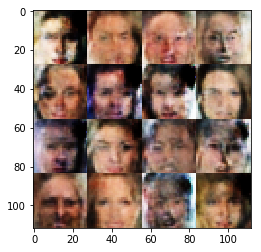

Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.3229
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 1.0308
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.0948
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.5416
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 1.1877
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 1.1442
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.2367
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 0.9996


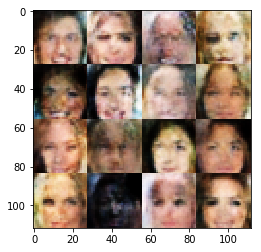

Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.0763
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 1.0734
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 1.2954
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 1.0818
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.1295


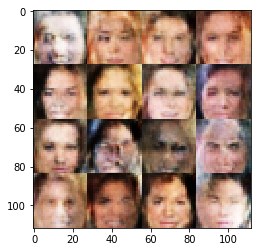

Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 1.6107
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 2.1164
Epoch 1/1... Discriminator Loss: 0.7737... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 0.8323... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 0.9089
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 0.9566


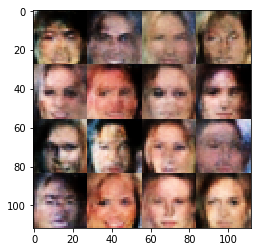

Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 2.0195
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.6833
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.1721
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.8747


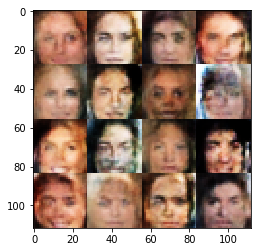

Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 1.5139
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 1.6025
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 1.0808
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 1.7336
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 0.9020


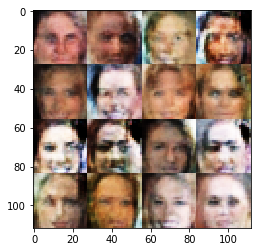

Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.2675
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 1.2349
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 1.6965


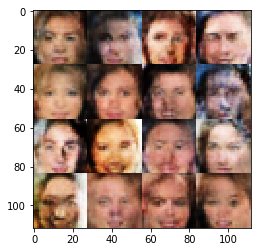

Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.8357


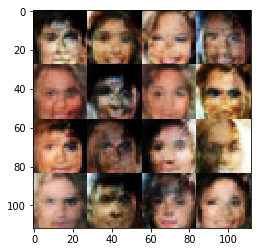

Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 1.1081
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 1.1727
Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.9821


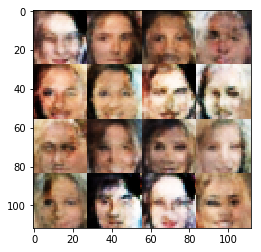

Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 1.5697
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.2033
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 1.2444
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 1.4140


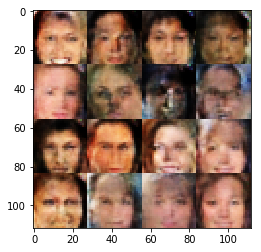

Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 1.0055
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.2025
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 1.3972


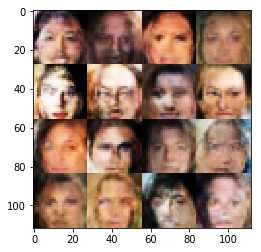

Epoch 1/1... Discriminator Loss: 0.8389... Generator Loss: 1.3180
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.1661
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 1.0084
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.9775


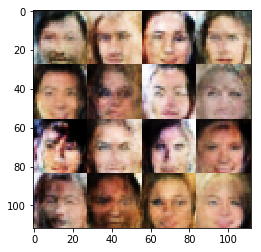

Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 1.4461
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 1.0947
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.9550


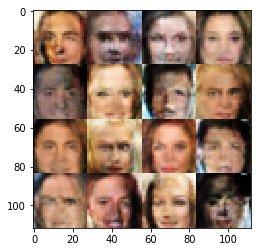

Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 1.4194
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 1.2450


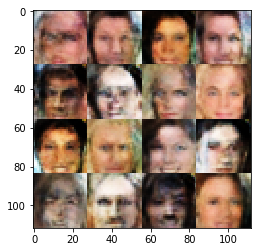

Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 1.4890
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 1.4474
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.2239
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 0.9951
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 1.0037


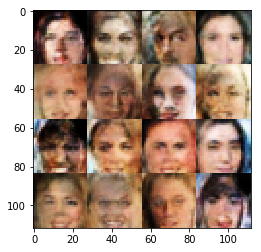

Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 1.4228
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 0.9617


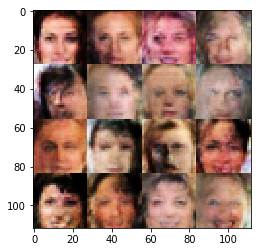

Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 0.9270


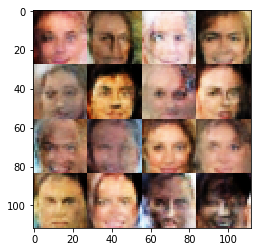

Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 1.6245


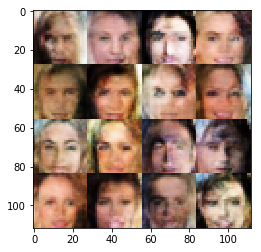

Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.0830
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.9376


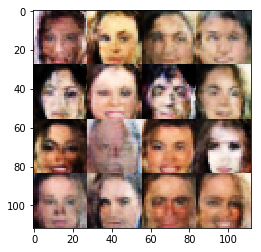

Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.2788
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 1.1310
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 1.0598


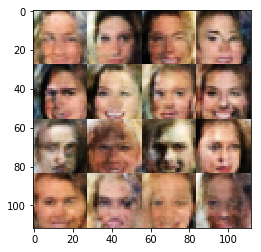

Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 1.4022
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 0.9366


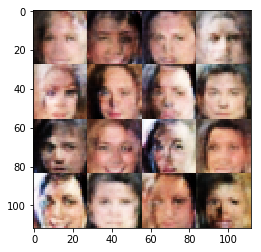

Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 1.2619
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.6068
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.0325


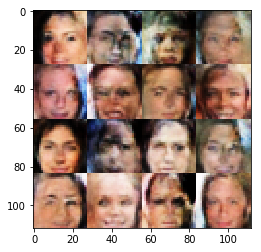

Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.3592
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.9083


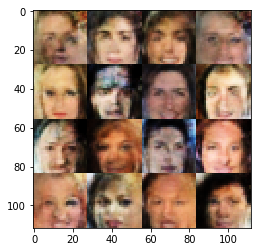

Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.0139
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.0367
Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 1.4011
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 1.8209


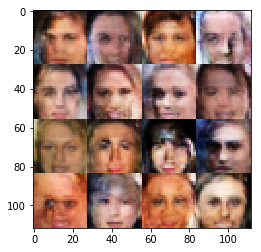

Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.0934
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 1.2011
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 0.9709... Generator Loss: 1.0716
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 2.1629


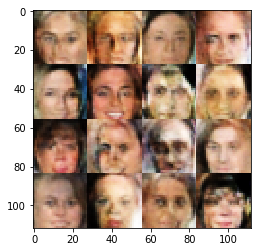

Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.8944


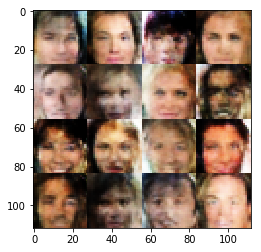

Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.2239
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.2413
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.8500


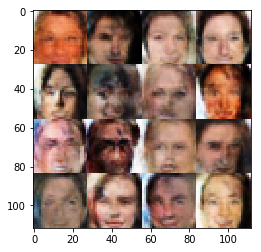

Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 1.2851
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 1.1436
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.9005


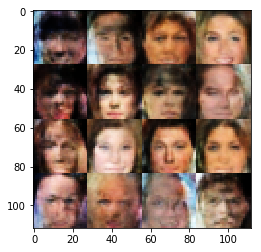

Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 0.8497... Generator Loss: 1.0066
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.9196


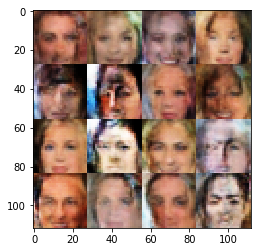

Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 1.1802
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 1.0522
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 1.8078
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 0.9529... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.9643


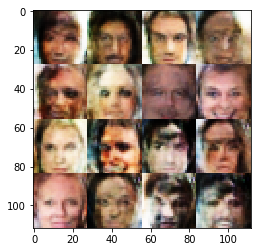

Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.0176... Generator Loss: 1.0782
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 1.1174


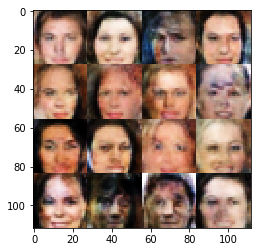

Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.0554
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.3255
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.9314


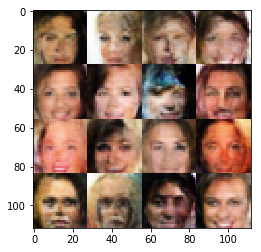

Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.5021
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.0636


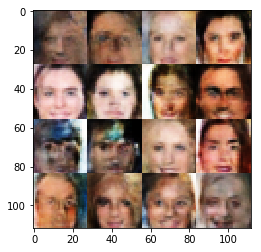

Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 1.0760
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 1.6438


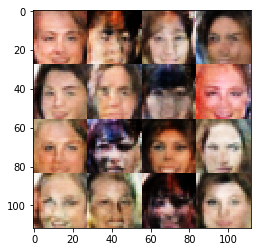

Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 0.9626
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 1.1366


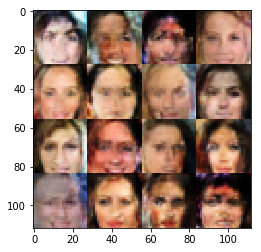

Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 0.8400


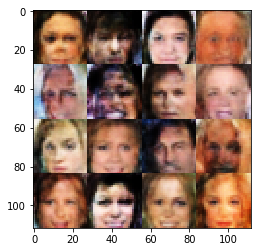

Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 0.9870... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 0.8374


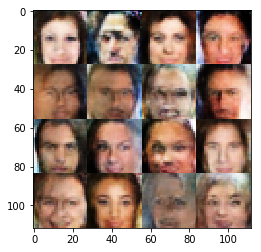

Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 1.3587
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.1180... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 1.0003


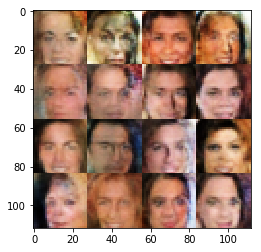

Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.8908


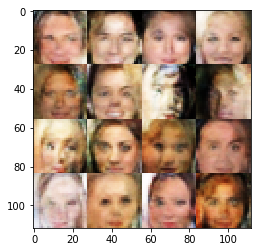

Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 1.0687
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 1.0637


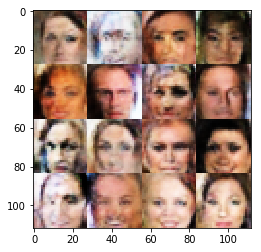

Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 1.5478
Epoch 1/1... Discriminator Loss: 0.9068... Generator Loss: 1.2886
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.2837
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.0683


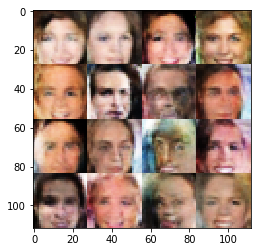

Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.1748
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.9947


IndexError: list index out of range

In [24]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.